In [1]:
import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

###   t-SNE, UMAP and LargeVis

In this and the next notebook we will use manifold learning for data visualization of large data sets (with high dimensionality). In addition to t-SNE, two relatively new methods will be used that are more efficient on large data sets.


- UMAP (Uniform Manifold Approximation and Projection) - Install this Python package: https://umap-learn.readthedocs.io/en/latest/index.html. UMAP package is compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. UMAP can work as a drop in replacement for t-SNE and other dimension reduction classes from scikit-learn


- LargeVis (Visualizing Large-scale and High-dimensional Data) - Many techniques (like t-SNE, UMAP and LargeVis) first compute a similarity structure of the data points and then project them into a low-dimensional space with the structure preserved. These two steps suffer from considerable computational costs Comparing to tSNE, LargeVis significantly reduces the computational cost of the graph construction step and employs a principled probabilistic model for the visualization step, the objective of which can be effectively optimized through asynchronous stochastic gradient descent with a linear time complexity. Download this algorithm repository and follow the installation instructions. https://github.com/lferry007/LargeVis


In [2]:
from cuml.manifold import TSNE
import umap

To get data we use the sklearn.datasets.fetch_openml method, which as the name requires, Fetch dataset from openml by name or dataset id. We will use MNIST and Fashion-MNIST(Zalando's article images). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Instead of numbers it contains thumbnails of clothes images.

In [3]:
mnist = sklearn.datasets.fetch_openml('mnist_784')
fmnist = sklearn.datasets.fetch_openml('Fashion-MNIST')

Below are drawings of some samples from mnist and fmnist data sets

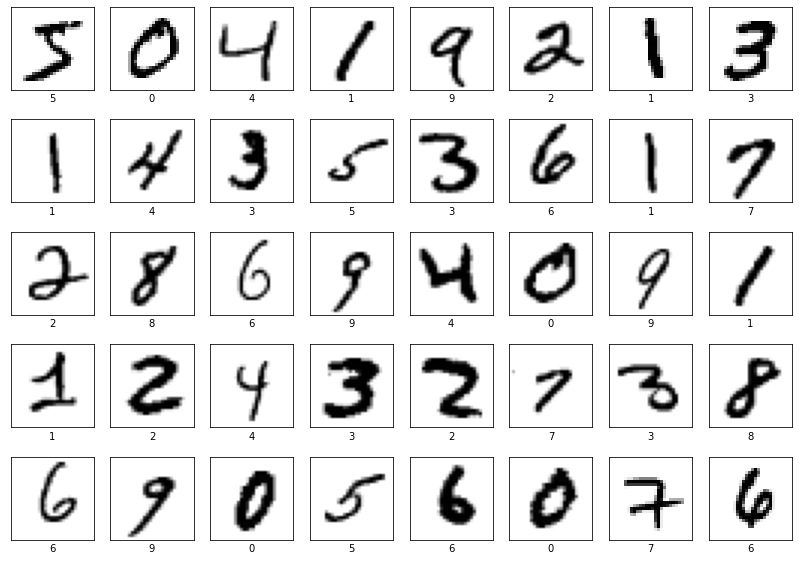

In [4]:
mnist_names = [i for i in range(10)]
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #     plt.imshow(mnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.imshow(mnist.data.values[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

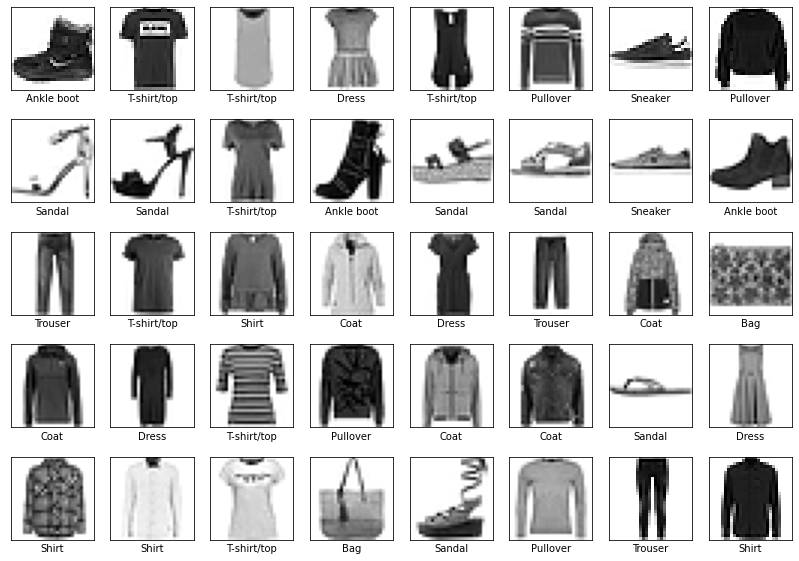

In [5]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist.data.values[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

#### Use t-SNE, UMAP and LargeVis to project mnist and fmnist data sets into a 2-dimensional space. For LargeVis, you need to create a function that saves the data to the required by LargeVis txt file format, and a function that loads the resulting file. Draw charts for all visualizations.

## UMAP

In [6]:
def umap_vis(embedding, target, title, custom_labels=None):
    fig, ax = plt.subplots(figsize=(12, 10))
    color = target.astype(int)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
    
    if custom_labels is not None:
        cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
        cbar.set_ticks(np.arange(10))
        cbar.set_ticklabels(custom_labels)
    else:
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Classes")
        ax.add_artist(legend)
    
    plt.title(f"UMAP for {title}", fontsize=18)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### MNIST

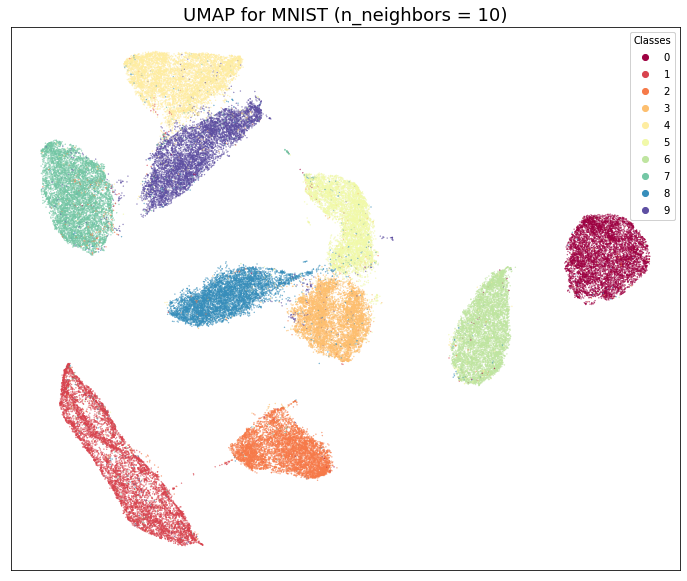

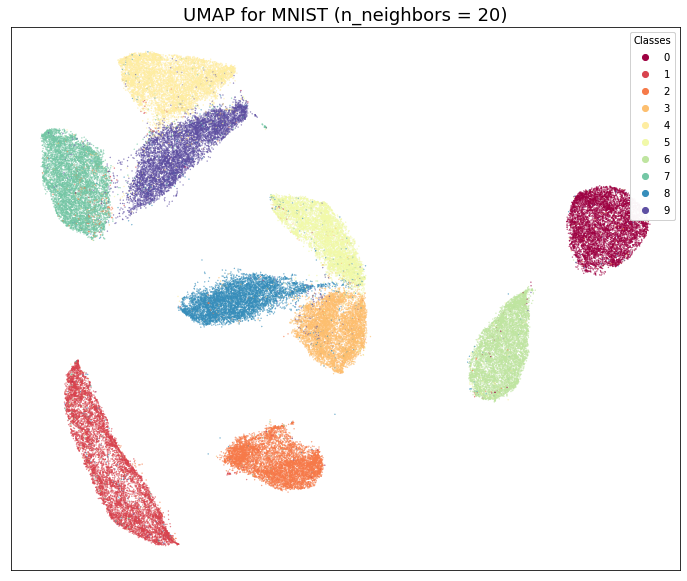

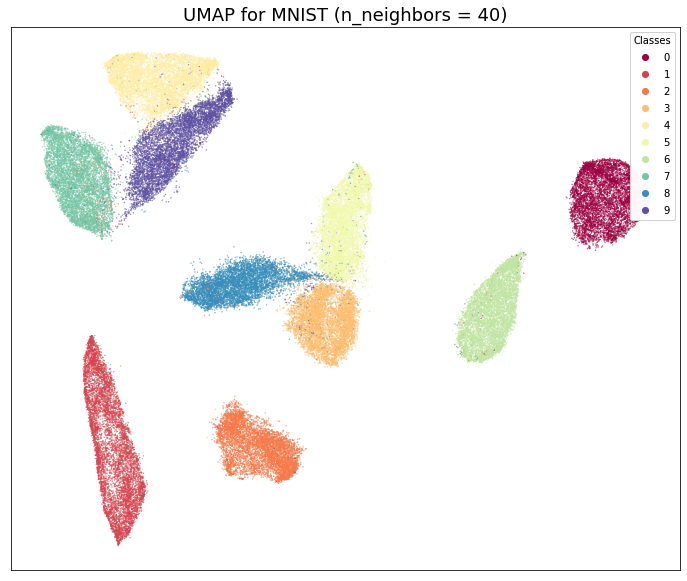

In [7]:
n_neighbors = [10, 20, 40]

for n in n_neighbors:
    reducer = umap.UMAP(random_state=42, n_neighbors=n)
    embedding = reducer.fit_transform(mnist.data)
    umap_vis(embedding, mnist.target, f'MNIST (n_neighbors = {n})')

UMAP grupuje cyfry w poszczególne klasy, jak i zachowuje ogólną strukturę między różnymi klasami. Metoda ta zachowuje 1 daleko od 0 oraz grupuje 3,5,8 i 4,7,9 razem (w ostatnim przypadku cyfry te są stosunkowo do siebie podobne).

Metodę przetestowano dla 3 różnych wartości parametru n_neighbors = [10, 20, 40]. Najlepsze rodzielenie klas otrzymano dla n_neighbors=10.

In [8]:
reducer_mnist = umap.UMAP(random_state=42, n_neighbors=10)
embedding_mnist = reducer.fit_transform(mnist.data)

### FASHION MNIST

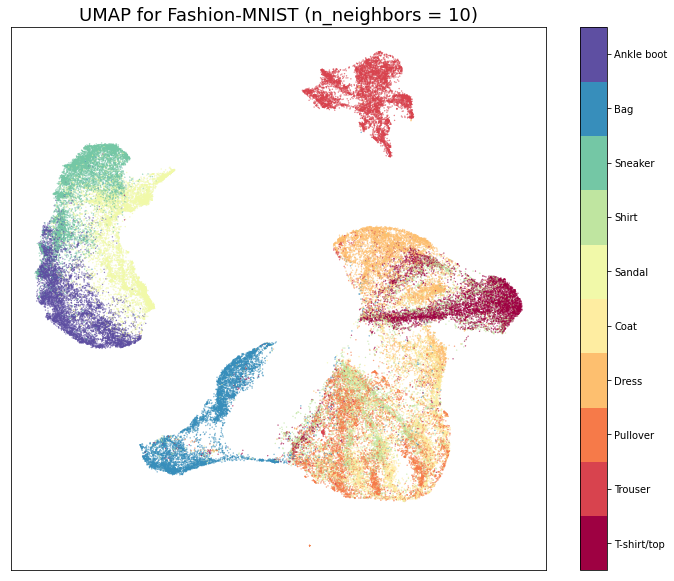

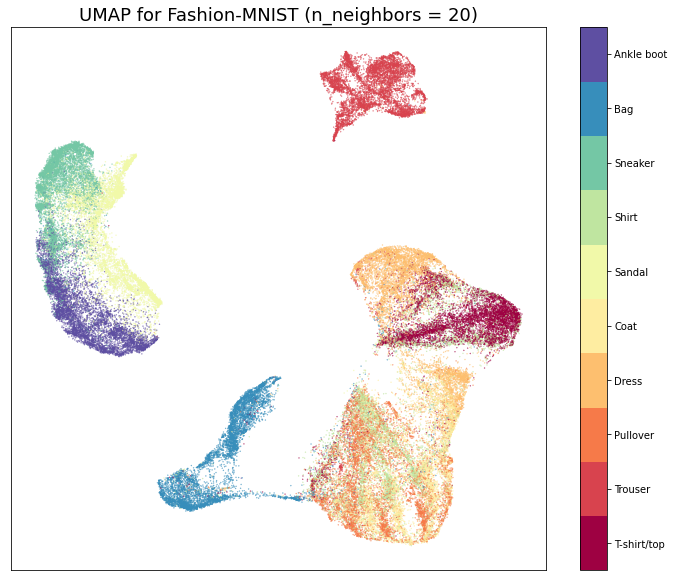

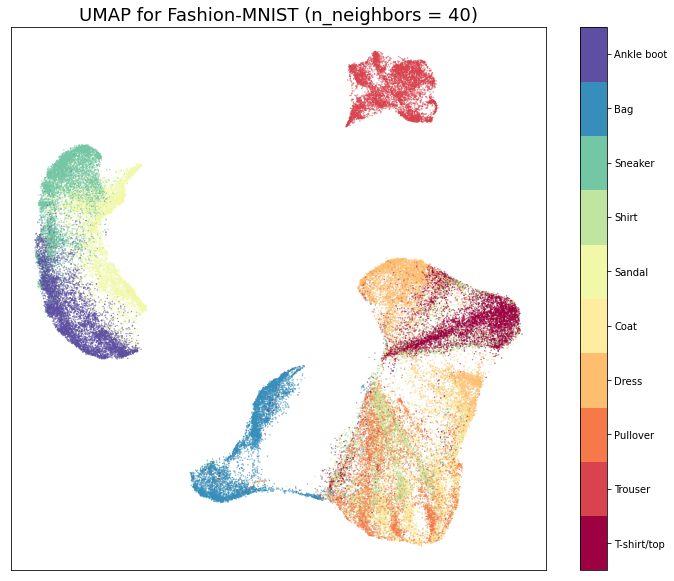

In [9]:
n_neighbors = [10, 20, 40]

for n in n_neighbors:
    reducer = umap.UMAP(random_state=42, n_neighbors=n)
    embedding = reducer.fit_transform(fmnist.data)
    umap_vis(embedding, fmnist.target, f'Fashion-MNIST (n_neighbors = {n})', custom_labels=fmnist_names)

In [10]:
reducer_fmnist = umap.UMAP(random_state=42, n_neighbors=10)
embedding_fmnist = reducer_fmnist.fit_transform(fmnist.data)

Bardzo dobrze rozdzielone zostały klasy: trouser i bag. Różne rodzaje butów (Ankle boot, Sneaker, Sandal) zostały zgrupowane razem, jednak nadal dostrzegalny jest podział między nimi. Duże podobieństwo między klasami: Shirt, Coat, Dress, Pullover i T-shirt/top spowodowało, że zostały one zobrazowane jako jedna grupa, gdzie podział nie jest jednoznaczny.

Metodę przetestowano dla 3 różnych wartości parametru n_neighbors = [10, 20, 40]. Najlepsze rodzielenie klas otrzymano dla n_neighbors=10

#### In order to compare the results of these three methods, calculate for each case the average distance between two points belonging to the same class divided by the average distance between points belonging to 2 different classes

In [11]:
from scipy.spatial.distance import cdist

In [12]:
def calc_distance(embedding, target, metric='euclidean'):
    ''' Calculate the average distance between two points 
    from 2 different classes (or within the same class) '''
    
    data = np.concatenate((embedding, target.reshape(-1, 1)), axis=1)
    df = pd.DataFrame(data=data, columns=['embed1', 'embed2', 'target'])
    
    results = []
    for base_target in np.unique(target):
        single_class_buffer = []
        for compare_target in np.unique(target):
            base_class_records = df[df['target']==base_target]
            base_coord = base_class_records.loc[:, ['embed1', 'embed2']].values.astype('float32')
            compare_class_records = df[df['target']==compare_target]
            compare_coord = compare_class_records.loc[:, ['embed1', 'embed2']].values.astype('float32')         
            avg_dist = np.mean(cdist(base_coord, compare_coord, metric))
            single_class_buffer.append(avg_dist)
        results.append(single_class_buffer)
    return np.array(results)

def plot_distances_heatmap(distance, dataset_name, method_name, ticklabels=None):
    ''' Visualize distances between classes using heatmap'''
    
    plt.figure(figsize=(15,12))
    sn.heatmap(distance, annot=True)
    plt.title(f'Average distance between 2 points for {dataset_name} dataset using {method_name} method')
    plt.xlabel('comparison class')
    plt.ylabel('base class')
    if ticklabels is not None:
        # set custom ticks labels
        xlocs, xlabels = plt.xticks()
        plt.xticks(xlocs, labels=ticklabels)
        ylocs, ylabels = plt.yticks()
        plt.yticks(ylocs, labels=ticklabels)
    plt.show()
    
def calc_performance_metric(distance):
    ''' Return the average distance between two points belonging to the same class 
    divided by the average distance between points belonging to 2 different classes'''
    
    diagonal_sum = np.trace(distance)
    total_sum = np.sum(distance)
    metric = diagonal_sum / (total_sum - diagonal_sum)
    return metric

### UMAP on MNIST performance measurement

In [13]:
%%time
distance_mnist_umap = calc_distance(embedding_mnist, mnist.target.to_numpy())

Wall time: 53.5 s


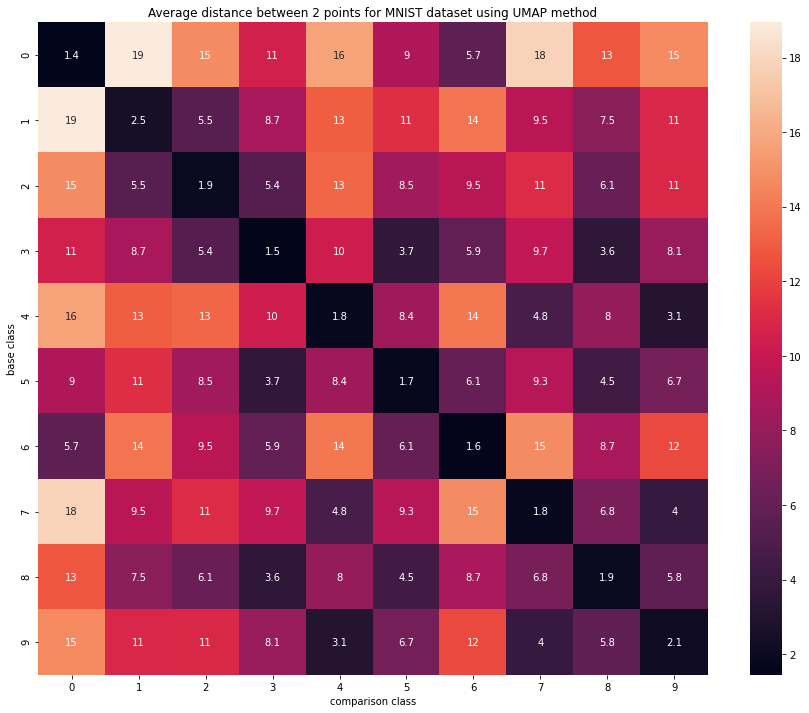

In [14]:
plot_distances_heatmap(distance_mnist_umap, 'MNIST', 'UMAP')

In [15]:
print(f'Performance metric for UMAP method on MNIST dataset')
print(f'{calc_performance_metric(distance_mnist_umap):.4f}')

Performance metric for UMAP method on MNIST dataset
0.0215


### UMAP on fashion-MNIST performance measurement

In [16]:
%%time
distance_fmnist_umap = calc_distance(embedding_fmnist, fmnist.target.to_numpy())

Wall time: 53.3 s


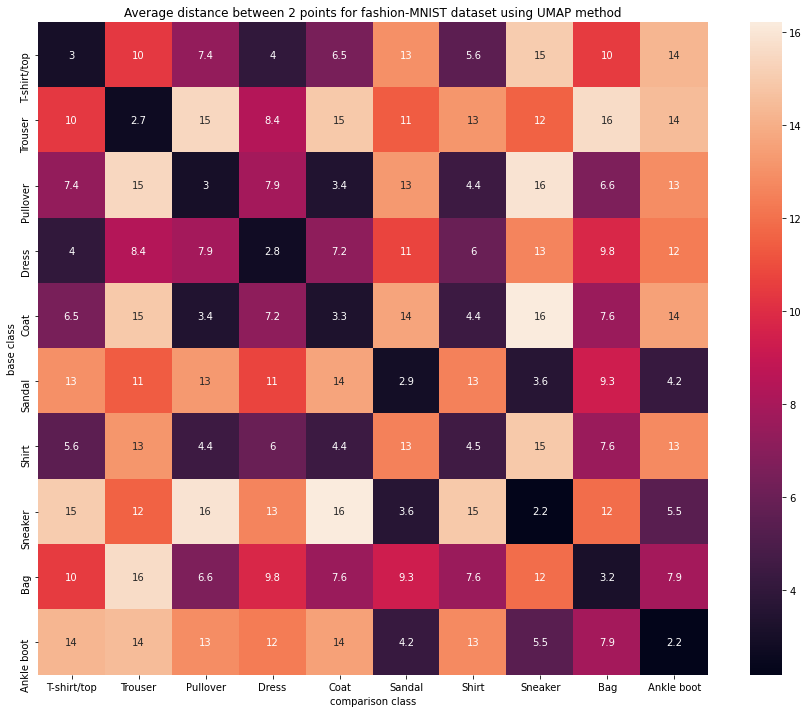

In [17]:
plot_distances_heatmap(distance_fmnist_umap, 'fashion-MNIST', 'UMAP', fmnist_names)

In [18]:
print(f'Performance metric for UMAP method on f-MNIST dataset')
print(f'{calc_performance_metric(distance_fmnist_umap):.4f}')

Performance metric for UMAP method on f-MNIST dataset
0.0325


## LargeVis

In [19]:
reduced = 10000
mnistReducedData = mnist.data.values[:reduced]
mnistReducedTarget = mnist.target[:reduced]

In [20]:
import LargeVis

In [21]:
def saveToTxt(data,filename="input.txt"):
    np.savetxt(filename,data,header="{} {}".format(len(data),len(data[0])), comments="",fmt="%u")

In [22]:
filename = "mnist.txt"
saveToTxt(mnistReducedData,filename = "mnist.txt")

In [ ]:
# %%time
# filename = "mnist.txt"
# perplexities = [10,20,30,40]
# for perplexity in perplexities:
#     LargeVis.loadfile(filename)
#     LargeVis_MNIST = np.array(LargeVis.run(2, -1, -1, -1, -1, -1, -1, -1, -1, perplexity))
#     distance_mnist_largeVis = calc_distance(LargeVis_MNIST, mnistReducedTarget.to_numpy())
#     print(f'perplexity[{perplexity}]:{calc_performance_metric(distance_mnist_largeVis):.4f}')

Dla perplexity 30 LargeVis daje najlepsze wyniki

In [23]:
LargeVis.loadfile(filename)
LargeVis_MNIST = np.array(LargeVis.run(2, -1, -1, -1, -1, -1, -1, -1, -1, 30))

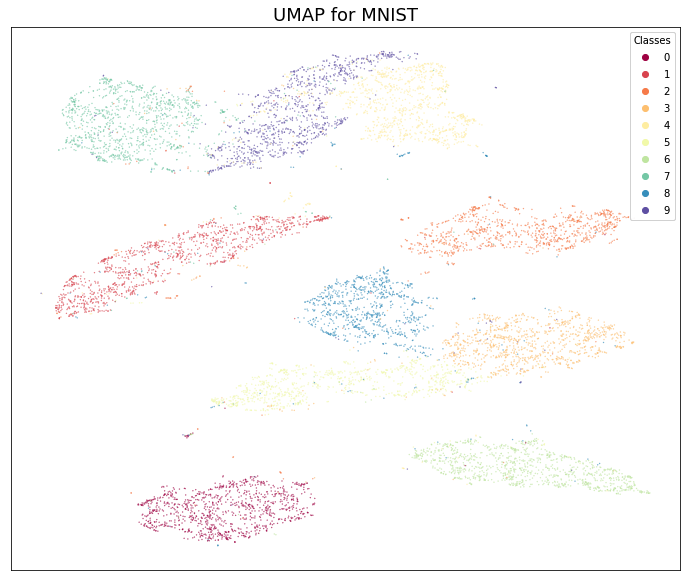

In [25]:
umap_vis(LargeVis_MNIST, mnistReducedTarget , 'MNIST')

In [26]:
fmnistReducedData = fmnist.data.values[:reduced]
fmnistReducedTarget = fmnist.target[:reduced]

In [27]:
filename = "fmnist.txt"
saveToTxt(fmnistReducedData,filename)

In [ ]:
# %%time
# filename = "fmnist.txt"
# perplexities = [10,20,30,40]
# for perplexity in perplexities:
#     LargeVis.loadfile(filename)
#     LargeVis_FMNIST = np.array(LargeVis.run(2, -1, -1, -1, -1, -1, -1, -1, -1, perplexity))
#     distance_fmnist_largeVis = calc_distance(LargeVis_FMNIST, fmnistReducedTarget.to_numpy())
#     print(f'perplexity[{perplexity}]:{calc_performance_metric(distance_fmnist_largeVis):.4f}', flush=True)

Dla perplexity 20 LargeVis daje najlepsze wyniki

In [28]:
%%time
LargeVis.loadfile(filename)
LargeVis_FMNIST = np.array(LargeVis.run(2, -1, -1, -1, -1, -1, -1, -1, -1, 20))

Wall time: 11min 13s


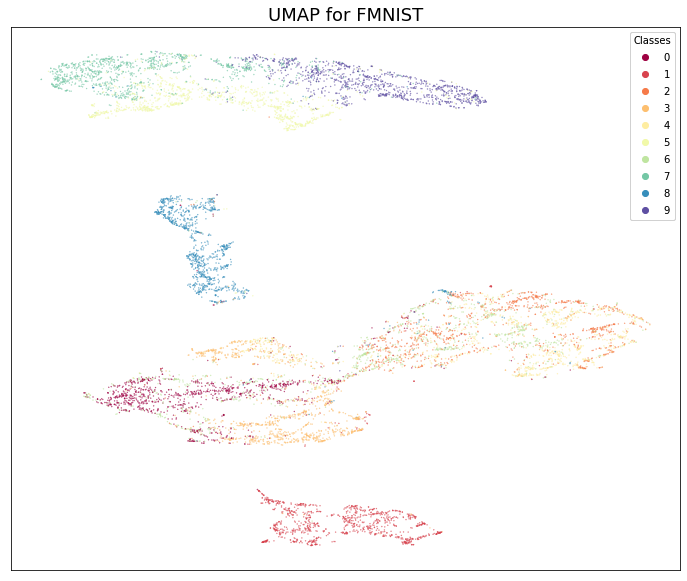

In [30]:
umap_vis(LargeVis_FMNIST, fmnistReducedTarget , 'FMNIST')

### LargeVis on MNIST performance measurement

In [31]:
%%time
distance_mnist_largeVis = calc_distance(LargeVis_MNIST, mnistReducedTarget.to_numpy())

Wall time: 3.76 s


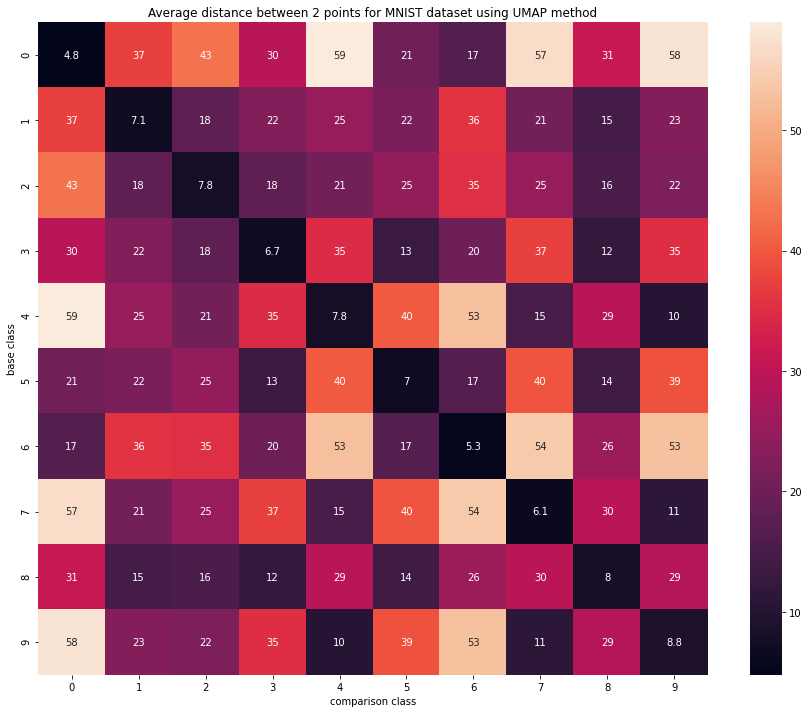

In [32]:
plot_distances_heatmap(distance_mnist_largeVis, 'MNIST', 'UMAP')

In [33]:
print(f'Performance metric for largeVis method on MNIST dataset')
print(f'{calc_performance_metric(distance_mnist_largeVis):.4f}')

Performance metric for largeVis method on MNIST dataset
0.0266


### LargeVis on fashion-MNIST performance measurement

In [36]:
%%time
distance_fmnist_largeVis = calc_distance(LargeVis_FMNIST, fmnistReducedTarget.to_numpy())

Wall time: 1.32 s


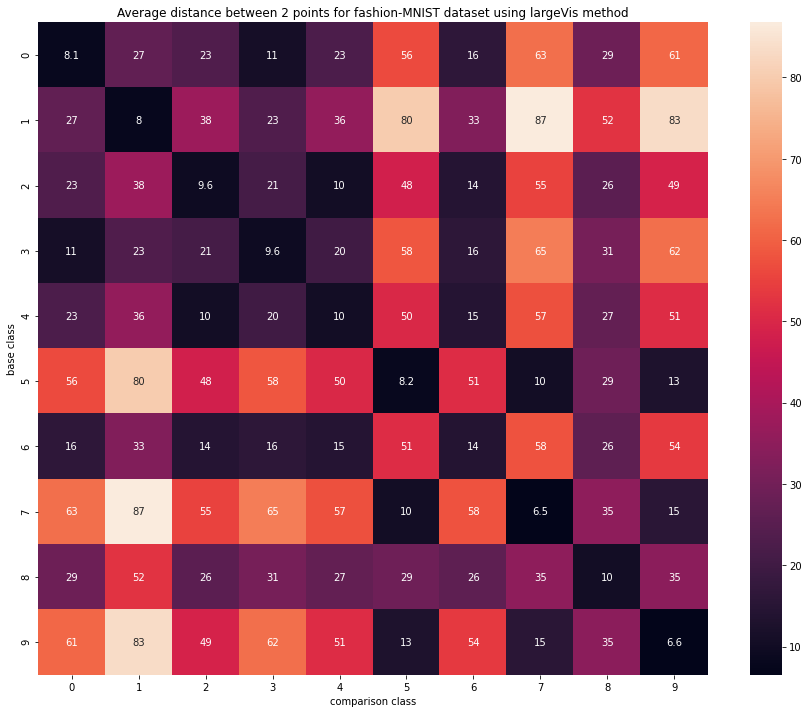

In [37]:
plot_distances_heatmap(distance_fmnist_largeVis, 'fashion-MNIST', 'largeVis')

In [38]:
print(f'Performance metric for largeVis method on f-MNIST dataset')
print(f'{calc_performance_metric(distance_fmnist_largeVis):.4f}')

Performance metric for largeVis method on f-MNIST dataset
0.0263


## t-SNE

In [17]:
def tsne_vis(embedding, target, title, custom_labels=None):
    fig, ax = plt.subplots(figsize=(12, 10))
    color = target.astype(int)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
    
    if custom_labels is not None:
        cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
        cbar.set_ticks(np.arange(10))
        cbar.set_ticklabels(custom_labels)
    else:
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Classes")
        ax.add_artist(legend)
    
    plt.title(f"t-SNE for {title}", fontsize=18)
    plt.xticks([])
    plt.yticks([])
    plt.show()

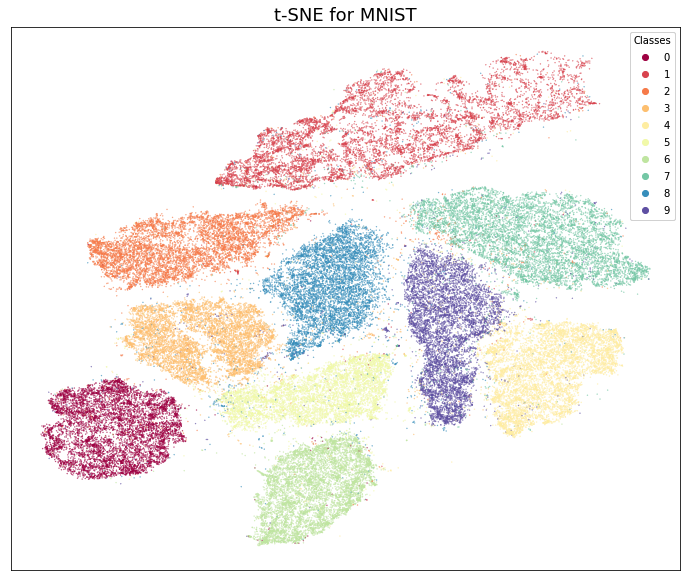

In [18]:
reducer_tsne_mnist = TSNE(n_components=2, metric='euclidean', perplexity=35)
embedding_mnist_tsne = reducer_tsne_mnist.fit_transform(mnist.data)

tsne_vis(embedding_mnist_tsne, mnist.target, 'MNIST')

Wykorzystanie metody t-SNE na zbirze MNIST doprowadziło do dobrego pogrupowania poszczególnych klas, jednak otrzymane odległości pomiędzy nimi są znacznie mniejsze i mniej wyraźle niż w przypadku metody UMAP. Dodatkowo niektóre z klas mieszają się ze sobą (np. 4 z 9 i 8 z 3).

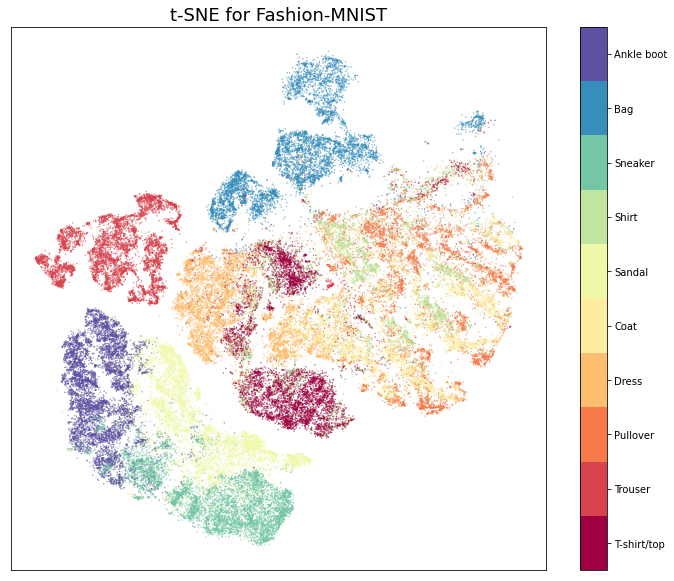

In [19]:
reducer_tsne_fmnist = TSNE(n_components=2, metric='euclidean', perplexity=40)
embedding_fmnist_tsne = reducer_tsne_fmnist.fit_transform(fmnist.data)

tsne_vis(embedding_fmnist_tsne, fmnist.target, 'Fashion-MNIST', custom_labels=fmnist_names)

Wykorzystanie metody t-SNE na zbirze FashionMNIST doprowadziło do w większości przypadków do niskiej seperacji klas, większość z nich miesza się ze sobą i nachodzi na siebie. Jedynymi dostatecznie odeseperowanymi klasami są niebieska - Bag oraz czerwona - Trouser. Klasy odpowiadające różnym rodzają butów (Sneaker, Sandal oraz Ankle boot) dość mocno się ze sobą mieszają, jednak widać pewne pogrupowanie, podczas gdy klasy Coat, Dress, Pullover oraz T-shirt/Top połączone są ze sobą i trudno wizualnie odseparować je od siebie. 

### t-SNE on MNIST performance measurement

In [20]:
%%time
distance_mnist_tsne = calc_distance(embedding_mnist_tsne, mnist.target)

CPU times: user 21.4 s, sys: 6.79 s, total: 28.2 s
Wall time: 28.2 s


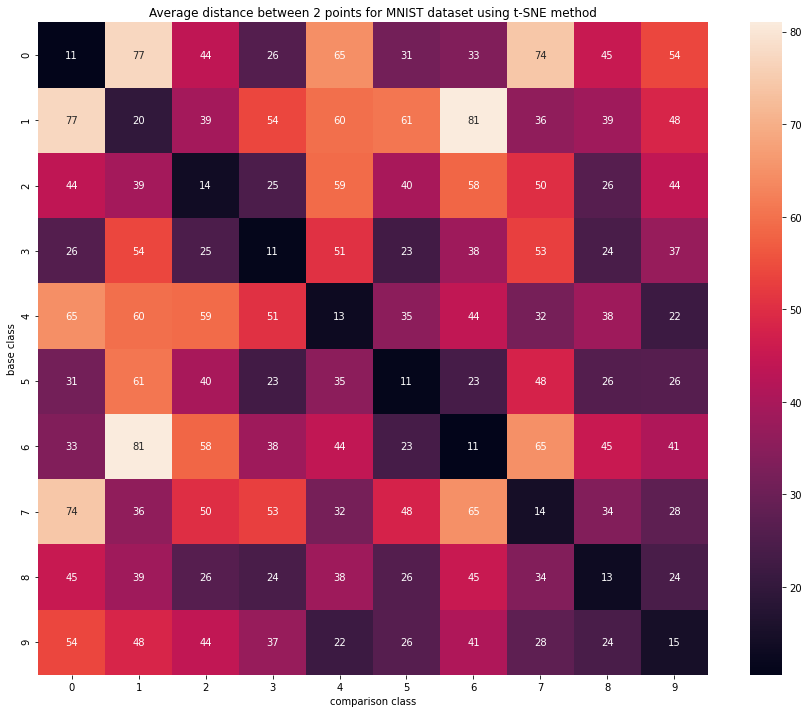

In [21]:
plot_distances_heatmap(distance_mnist_tsne, 'MNIST', 't-SNE')

In [22]:
print(f'Performance metric for t-SNE method on MNIST dataset')
print(f'{calc_performance_metric(distance_mnist_tsne):.4f}')

Performance metric for t-SNE method on MNIST dataset
0.0343


### t-SNE on fashion-MNIST performance measurement

In [23]:
%%time
distance_fmnist_tsne = calc_distance(embedding_fmnist_tsne, fmnist.target)

CPU times: user 21.6 s, sys: 6.84 s, total: 28.5 s
Wall time: 28.5 s


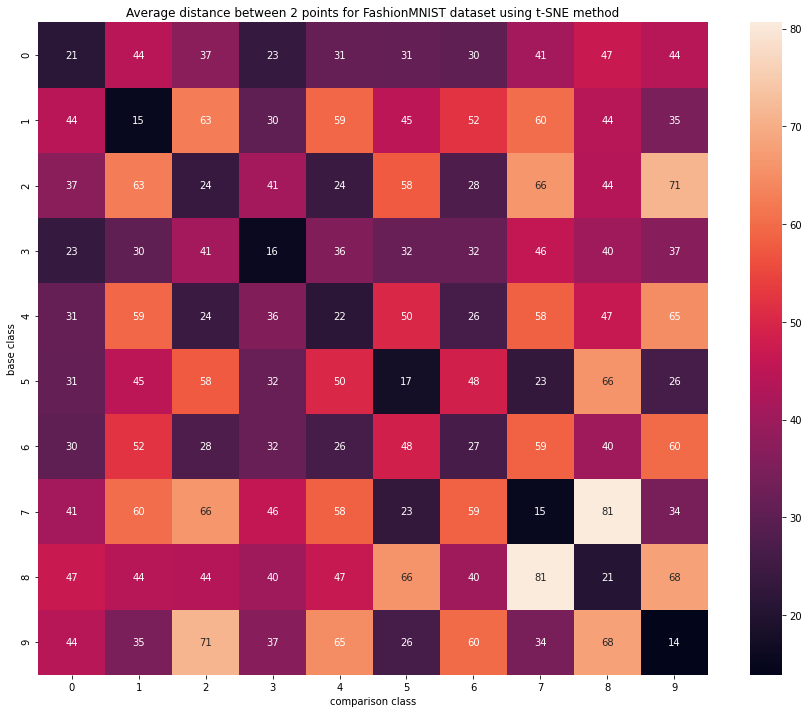

In [24]:
plot_distances_heatmap(distance_fmnist_tsne, 'FashionMNIST', 't-SNE')

In [25]:
print(f'Performance metric for t-SNE method on FashionMNIST dataset')
print(f'{calc_performance_metric(distance_fmnist_tsne):.4f}')

Performance metric for t-SNE method on FashionMNIST dataset
0.0473


## Wyniki

Porównanie wyników działania metod UMAP, t-SNE oraz LargeVIS w metryce obliczającej stosunek średniego dystansu punktów tej samej klasy od średniego dystansu pomiędzy punktami różnych klas.

### MNIST

UMAP - 0.0215

T-SNE - 0.0343

LargeVIS -  0.0266

### F-MNIST